### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2.1
!pip install gdown tensorboard
!pip install -U jupyter ipywidgets

------------

## Notebook: Embedding Generation (HLS Burn Scars Data)

This notebook demonstrates how to generate EO embeddings in TerraTorch using a pretrained FM backbone. TerraTorch supports no-code/low-code embedding generation via the `EmbeddingGenerationTask`, which can be paired with any existing datamodule. You can select which layers to extract from and optionally apply aggregation strategies. Embedding generation is handled through the Lightning predict workflow.

Below, we demonstrate this on the HLS BurnScars dataset. As with other TerraTorch workflows, embedding generation can also be run in a no-code manner using YAML config files.

As a follow-up, check out the embedding downstream task example notebooks to see how to load and use embeddings for downstream tasks.


In [4]:
import os
import sys
import torch
import gdown
import terratorch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### 1. Importing the relevant components

We import the datamodule and task needed for this workflow:

- We use the `GenericNonGeoSegmentationDataModule` to load the HLS data. Labels aren't required and we will only use the predict workflow. The exact choice of datamodule is therefore not essential, as long as it is compatible with the input image format (e.g. using a multimodal datamodule for inputs with multiple modalities).
- Crucially, we use the `EmbeddingGenerationTask` to extract and save embeddings, rather than training a downstream model directly.


In [5]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
from terratorch.tasks import EmbeddingGenerationTask

### 2. Downloading the input image data

In [ ]:
# This version is an adaptation from https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars (same data, updated folder structure) with splits from https://github.com/IBM/peft-geofm/tree/main/datasets_splits/burn_scars. You can also download the original data from Hugging Face.

dataset_path = Path('hls_burn_scars') # Path to the extracted dataset (change this if your data lives elsewhere)
archive_path = dataset_path.with_suffix(".tar.gz")

#Download archive if it does not exist
if not archive_path.is_file():
    gdown.download("https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC")

# Extract archive if dataset directory does not exist
if not dataset_path.is_dir():
    !tar -xzf {archive_path}

### 3. Building the Datamodule

This step is independent of the embedding generation, so you can follow the standard TerraTorch datamodule examples if you are working with different input data. The main aspects to pay attention to here are the predict data root (data that will be embedded) as well as any configuration that affects the image data itself (e.g. normalization means and standard deviations, predict transformations).

In [8]:
datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=8,
    num_workers=2,
    num_classes=2,  # Required by the datamodule; not used for embedding generation
    check_stackability=False, # We can skip stackability check for dataset with a known, consistent input size

    train_data_root=None,  # We only need to define the predict dataroot
    val_data_root=None,
    test_data_root=None,
    predict_data_root=dataset_path / "data/",  # Embed all available input data (we don't use any split files or subfolders)

    img_grep="*_merged.tif",  # BurnScars data uses the "_merged" suffix for input images

     # TerraMind pretraining values (assuming data in range 0-10000)
     means= [0.1503, 0.1718, 0.1853, 0.3132,0.2424, 0.1857],
     stds= [0.2141, 0.2038, 0.2134, 0.1753, 0.1434, 0.1334],

    no_data_replace=0,  # Replace no-data / NaNs
)

# Set up the datamodule for prediction
datamodule.setup("predict")

In [9]:
# Check the datamodule initialization and dataset length
dataset = datamodule.predict_dataset
print(f"Available input samples: {len(dataset)}")

Available input samples: 804


### 4. Building the embedding generation task

We use the `EmbeddingGenerationTask`, which can be configured with any available TerraTorch model as backbone. It allows you to control the output format, select which layers to extract embeddings from, optionally apply aggregation, and define where the embeddings are stored.

In [10]:
model = EmbeddingGenerationTask(

    # Select and configure the backbone model as in other TerraTorch workflows
    model_args={
        "backbone": "terramind_v1_small",
        "backbone_modalities": ["S2L2A"],
        "backbone_pretrained": True,
        "backbone_bands": {"S2L2A": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]},
    },

    # Embedding workflow–specific configuration
    output_format="tiff",  # Save embeddings as GeoTIFFs; ViT embeddings are reshaped to a spatial grid
    output_dir=dataset_path / "embeddings_terramind/",  # Output directory to store embeddings
    layers=[-1],  # Layers to extract embeddings from; "-1" indicates the final layer
    embedding_pooling=None,  # Keep dense embeddings (recommended for pixel-wise downstream tasks)
)


In [ ]:
# Before we generate the embeddings, we investigate the input and output shape to better understand the chosen configurations
dataloader = datamodule.predict_dataloader()

# We pick the first batch from our dataloader and extract the image input
batch = next(iter(dataloader))
images = batch["image"]

# Our model is confiugred with the FM backbone as well as necks that aggregate and reshape based on the given configurations
outputs = model(images)

print(f"Input batch shape: {images.shape}")
print(f"Length of Outputs: {len(outputs)}") # We requested only the final layer embedding so a list of len 1 is returned by the model
print(f"Input batch shape: {outputs[0].shape}") # The output contains 384 channels (embedding size ViT-Small) and is reshaped to spatial grid as we chose tiff as output format

In [12]:
# Generate embeddings
trainer = pl.Trainer(accelerator="auto")
_ = trainer.predict(model, datamodule=datamodule)

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101/101 0:00:17 • 0:00:00 5.87it/s

### 5. Other models

Following the same workflow as above, we generate dense TIFF embeddings for two additional backbones: The ViT-based Prithvi v2 tiny model and a ResNet-50 DINO model. We then analyze and compare the resulting embeddings using PCA for visual inspection.

Since this computes and saves dense embeddings for two additional backbones, you might want to skip this step to save memory and compute and instead just check out the changed configurations used and look at the visual analysis results below.

In [10]:
# As we change the backbone, we update the Normalization applied in the datamodule do the Prithvi pretraining values

from terratorch.datamodules.generic_pixel_wise_data_module import Normalize

means=[0.1087, 0.1342, 0.1433, 0.2734, 0.1958, 0.1363],
stds=[0.2248, 0.2179, 0.2178, 0.1850, 0.1242, 0.1049]

datamodule.aug = Normalize(means, stds)
datamodule.setup("predict")


In [ ]:
model = EmbeddingGenerationTask(

    model_args={
        "backbone": "prithvi_eo_v2_tiny_tl", # Change model backbone
        "backbone_pretrained": True,
        "backbone_img_size": 512,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    },

    output_format="tiff",
    output_dir=dataset_path / "embeddings_prithvi/",  # Adapt output directory to store embeddings
    layers=[-1],
    embedding_pooling=None,
    has_cls=True, # Prithvi produces a CLS token, which is omitted when reshaping embedding tokens back to an image (for TIFF outputs).
)

# Generate embeddings
trainer = pl.Trainer(accelerator="auto")
_ = trainer.predict(model, datamodule=datamodule)

In [12]:
# The SSL4EO pretrained models expect inputs scaled to [0, 1] but not standardized.
# Since our data already matches this format, we set mean=0 and std=1 to effectively
# skip the normalization step.

from terratorch.datamodules.generic_pixel_wise_data_module import Normalize

means = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
stds  = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

datamodule.aug = Normalize(means, stds)
datamodule.setup("predict")

In [13]:
model = EmbeddingGenerationTask(

    model_args={
        "backbone": "ssl4eos12_resnet50_sentinel2_all_dino", # Change model backbone
        "backbone_pretrained": True,
        "backbone_model_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    },

    output_format="tiff",
    output_dir=dataset_path / "embeddings_resnet_dino/",  # Adapt output directory to store embeddings
    layers=[-1],
    embedding_pooling=None,
)

# Generate embeddings
trainer = pl.Trainer(accelerator="auto")
_ = trainer.predict(model, datamodule=datamodule)

In [14]:
from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from terratorch.datasets.utils import to_pca_rgb

def load_raw_rgb(path: Path) -> np.ndarray:
    """Load raw image and process to RGB"""
    with rasterio.open(path) as src:
        raw = src.read()  # (C, H, W)

    data = raw.astype(np.float32)
    if data.mean() < 1:
        data *= 10000.0

    data = (data.clip(0, 2000) / 2000) * 255.0
    rgb = data[[2, 1, 0]].astype(np.uint8).transpose(1, 2, 0)  # (H, W, 3)
    return rgb


def load_emb_pca_rgb(path: Path, *, step: int = 8) -> np.ndarray:
    """Load embedding GeoTIFF and map to PCA-RGB."""
    with rasterio.open(path) as src:
        emb = src.read().astype(np.float32)  # (C, H, W)

    emb_rgb, _, _ = to_pca_rgb(image_chw=emb, step=step)  # predefined in your notebook
    return emb_rgb

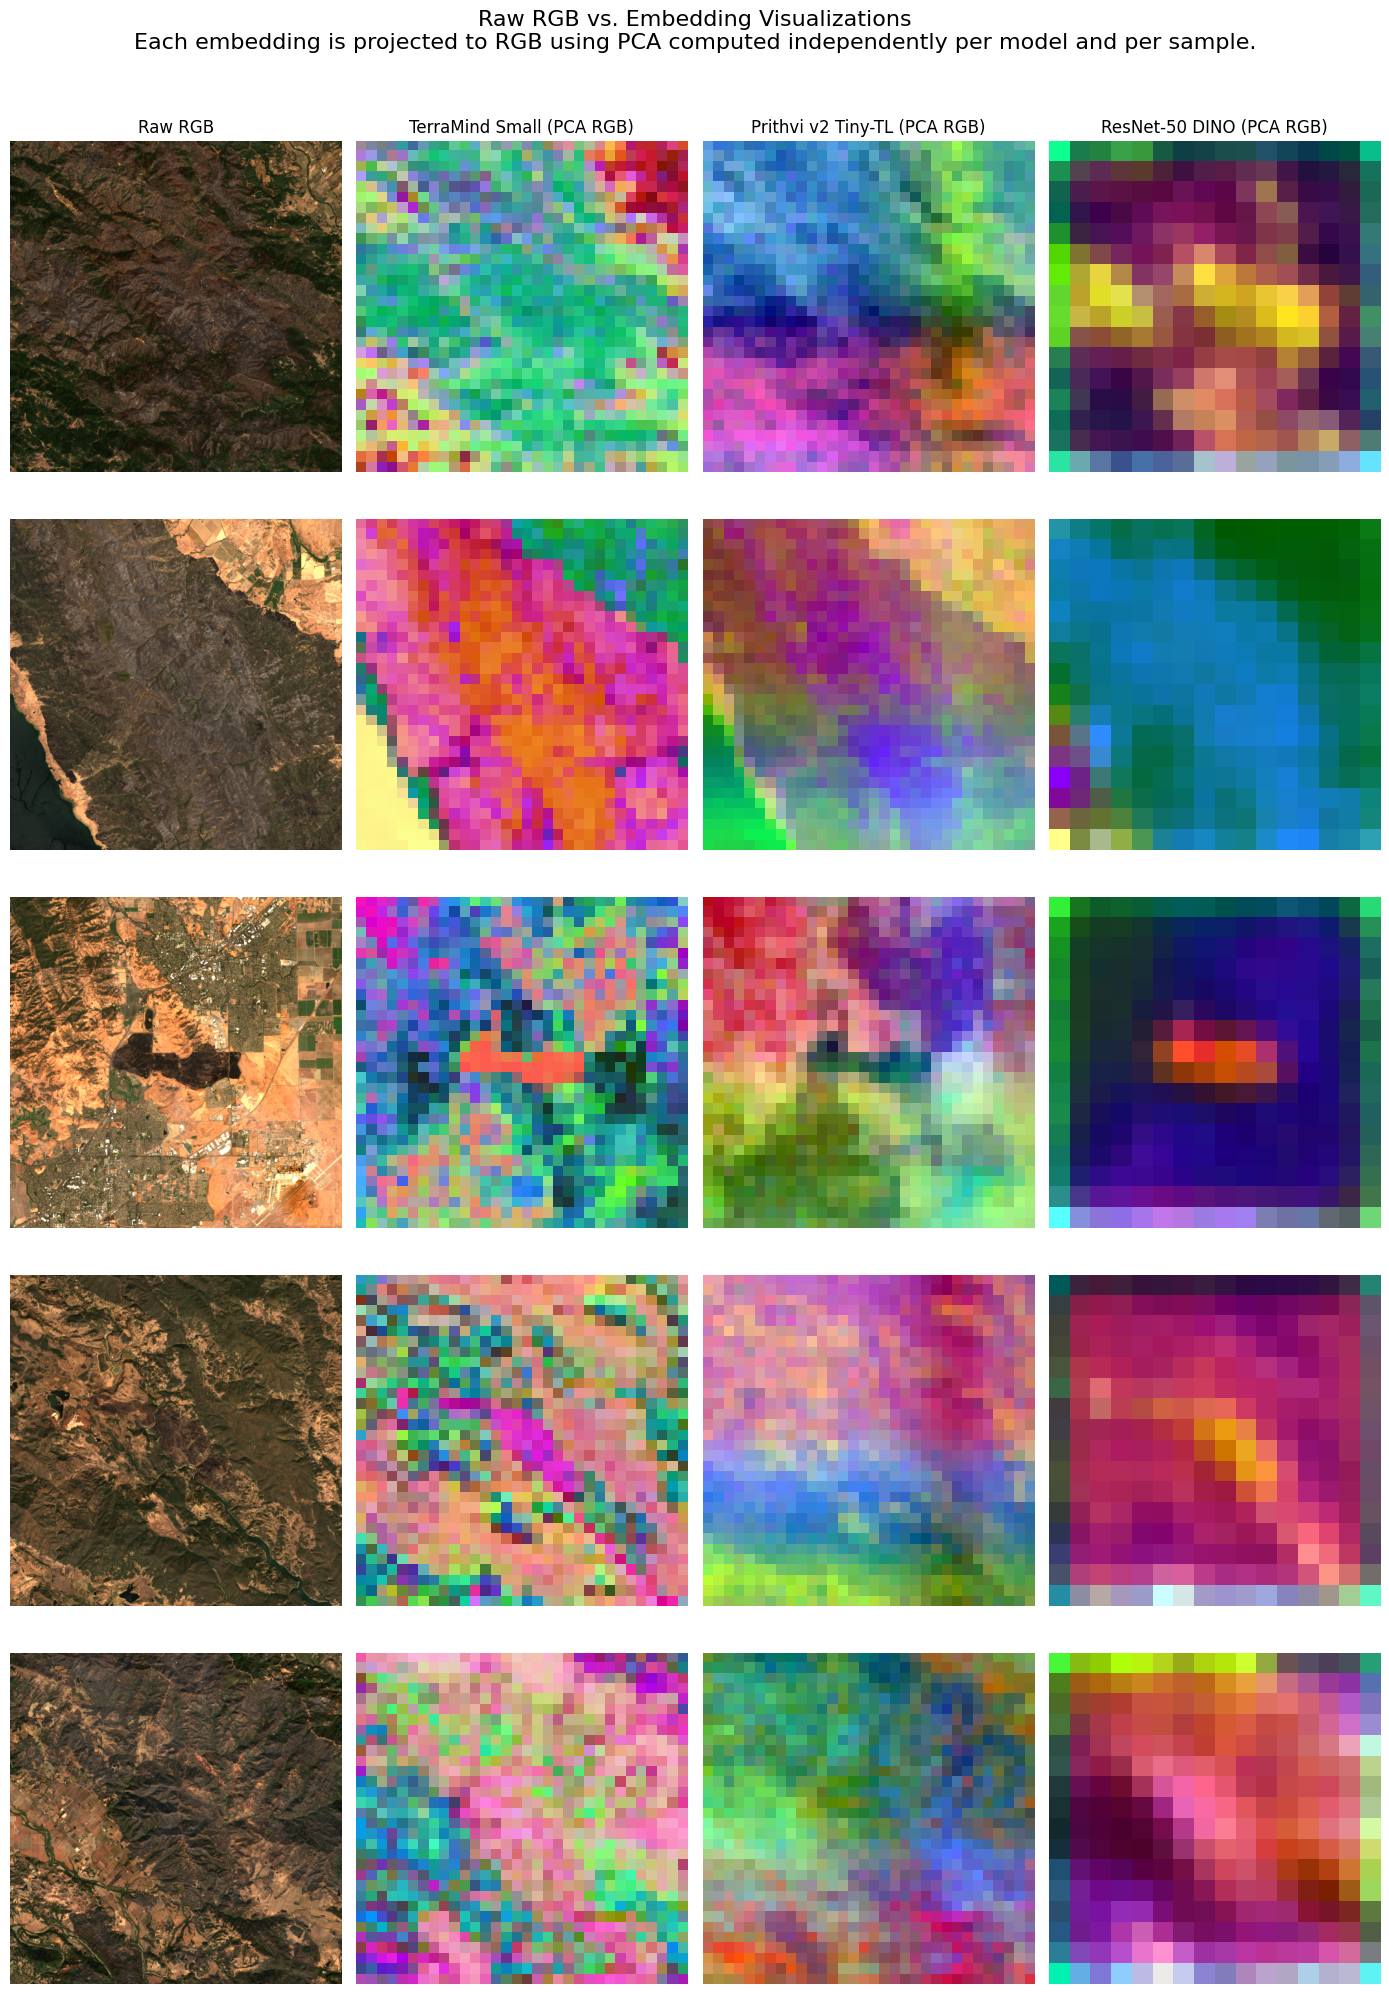

In [15]:
number_of_samples = 5 # Choose number of visualised samples

DATA_DIR = dataset_path / "data"
EMB_DIR_TERRAMIND = dataset_path / "embeddings_terramind/layer_00"
EMB_DIR_PRITHVI   = dataset_path / "embeddings_prithvi/layer_00"
EMB_DIR_DINO      = dataset_path / "embeddings_resnet_dino/layer_00"

raw_files = {p.stem.removesuffix("_merged"): p for p in DATA_DIR.glob("*_merged.tif")}
emb_files_tm  = {p.stem.removesuffix("_merged_embedding"): p for p in EMB_DIR_TERRAMIND.glob("*_merged_embedding.tif")}
emb_files_pr  = {p.stem.removesuffix("_merged_embedding"): p for p in EMB_DIR_PRITHVI.glob("*_merged_embedding.tif")}
emb_files_dn  = {p.stem.removesuffix("_merged_embedding"): p for p in EMB_DIR_DINO.glob("*_merged_embedding.tif")}

names = sorted(set(raw_files) & set(emb_files_tm) & set(emb_files_pr) & set(emb_files_dn))[:number_of_samples]
pairs = [(raw_files[n], emb_files_tm[n], emb_files_pr[n], emb_files_dn[n]) for n in names]

titles = ["Raw RGB", "TerraMind Small (PCA RGB)", "Prithvi v2 Tiny-TL (PCA RGB)", "ResNet-50 DINO (PCA RGB)"]
n = len(pairs)

fig, ax = plt.subplots(n, 4, figsize=(14, 4 * n), squeeze=False)

for i, (raw_path, tm_path, pr_path, dn_path) in enumerate(pairs):
    rgb_raw = load_raw_rgb(raw_path)
    rgb_tm  = load_emb_pca_rgb(tm_path, step=8)
    rgb_pr  = load_emb_pca_rgb(pr_path, step=8)
    rgb_dn  = load_emb_pca_rgb(dn_path, step=8)

    imgs = [rgb_raw, rgb_tm, rgb_pr, rgb_dn]

    for j, img in enumerate(imgs):
        ax[i, j].imshow(img)
        ax[i, j].set_title(titles[j] if i == 0 else "")
        ax[i, j].axis("off")

fig.suptitle(
    "Raw RGB vs. Embedding Visualizations\n"
    "Each embedding is projected to RGB using PCA computed independently per model and per sample.",
    fontsize=16,
    y=1.01,
)

plt.tight_layout()
plt.show()

### 6. Embedding Aggregation

Lastly, we look at an example that uses embedding aggregation (mean pooling) and writes the results to a joint Parquet file. As a sample analysis, we then inspect the generated Parquet file and compute an embedding-value histogram over the aggregated mean embeddings.

In [ ]:
# Terramind values
means= [0.1503, 0.1718, 0.1853, 0.3132,0.2424, 0.1857]
stds= [0.2141, 0.2038, 0.2134, 0.1753, 0.1434, 0.1334]

datamodule.aug = Normalize(means, stds)
datamodule.setup("predict")

model = EmbeddingGenerationTask(

    model_args={
        "backbone": "terramind_v1_small",
        "backbone_modalities": ["S2L2A"],
        "backbone_pretrained": True,
        "backbone_bands": {"S2L2A": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]},
    },

    output_format="parquet_joint",  # We change the output format
    output_dir=dataset_path / "embeddings_terramind_parquet/",
    layers=[-1],
    embedding_pooling='mean',  # And pick mean pooling
)

# Generate embeddings
trainer = pl.Trainer(accelerator="auto")
_ = trainer.predict(model, datamodule=datamodule)

rows, cols: (804, 2)
columns: ['file_id', 'embedding']

Aggregated Embeddings Shape (Samples, Size): (804, 384)



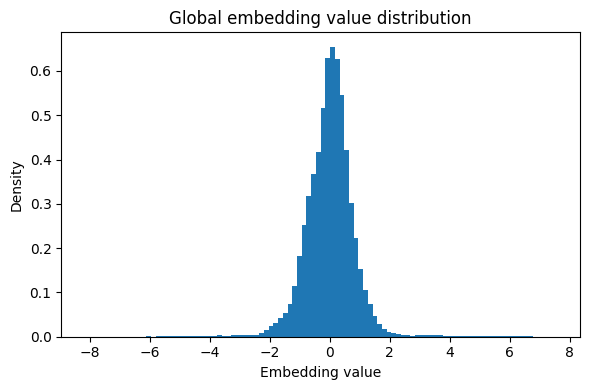

In [17]:
import pandas as pd

EMB_PARQUET = dataset_path / "embeddings_terramind_parquet/layer_00/embeddings.parquet"

df = pd.read_parquet(EMB_PARQUET)
print("rows, cols:", df.shape)
print("columns:", list(df.columns))
print()

embeddings = df["embedding"]
X = np.vstack(embeddings.values)   # shape: (N, D)
print("Aggregated Embeddings Shape (Samples, Size):", X.shape)
print()

X_flat = X.ravel()
plt.figure(figsize=(6, 4))
plt.hist(X_flat, bins=100, density=True)
plt.xlabel("Embedding value")
plt.ylabel("Density")
plt.title("Global embedding value distribution")
plt.tight_layout()
plt.show()

## Embedding Generation via CLI

Above, we introduced the required TerraTorch components and how to combine them flexibly. The same workflow can be run in a no-code setup by configuring all components in a YAML file and executing it via the PyTorch Lightning CLI.

We provide a sample YAML that reproduces the workflow above and serves as a starting point for similar pipelines.

**Note:** You may want to restart the session to free up memory before running the CLI workflow.

In [ ]:
!terratorch predict -c embedding_generation_burnscars.yaml